In [15]:
from cv2 import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import random

depth_images = ['./Dataset_Assignment_2/depth_0.jpg','./Dataset_Assignment_2/depth_1.jpg','./Dataset_Assignment_2/depth_2.jpg','./Dataset_Assignment_2/depth_3.jpg']

images = ['./Dataset_Assignment_2/im_0.jpg','./Dataset_Assignment_2/im_1.jpg','./Dataset_Assignment_2/im_2.jpg','./Dataset_Assignment_2/im_3.jpg']



In [32]:
im1 = images[1]
d1 = depth_images[1]
im2 = images[2]

image1 = cv2.imread(im1)
image2 = cv2.imread(im2)

depth_img1 = cv2.imread(d1)
#
m,n,_ = image1.shape

def get_keypoints(image):
    sift = cv2.SIFT_create()
    keyp,des = sift.detectAndCompute(image,None)
    
    return keyp,des

# here we are using the Lowe's ratio test for matching
def get_matchings(des1,des2):
    bf_matcher = cv2.BFMatcher()
    matchings = bf_matcher.knnMatch(des1,des2,k=2)
    matchings_list = []
    for a,b in matchings:
        if(a.distance<0.7*b.distance):
            matchings_list.append([a])
    return matchings_list

# we will now use the above functions to calculate the matches
keyp1,des1 = get_keypoints(image1)
keyp2,des2 = get_keypoints(image2)

quality_matchings = get_matchings(des1,des2)


# Now we are dividing the all depths interval into 5 levels
# we will use the m = 52
levels = [[],[],[],[],[]]
# for inbuilt homography
levels_query = [[],[],[],[],[]]
levels_train = [[],[],[],[],[]]


for i in range(len(quality_matchings)):
    img_coordinates = list(keyp1[quality_matchings[i][0].queryIdx].pt)
    img_coordinates2 = list(keyp2[quality_matchings[i][0].trainIdx].pt)
    
    x_coordinate = img_coordinates[0]
    y_coordinate = img_coordinates[1]
    x_coordinate1 = img_coordinates2[0]
    y_coordinate1 = img_coordinates2[1]
    
    
    depth = depth_img1[int(y_coordinate),int(x_coordinate)][0]
    # now we have inserted a particular point in accordance with its depth
    levels[int(np.floor(depth/52))].append([x_coordinate,y_coordinate,x_coordinate1,y_coordinate1])
    
    levels_query[int(np.floor(depth/52))].append(keyp1[quality_matchings[i][0].queryIdx].pt)
    levels_train[int(np.floor(depth/52))].append(keyp2[quality_matchings[i][0].trainIdx].pt)
    
    

# Here we are ensuring every one has got enough points else we are replacing it with its neighboour
for i in range(len(levels)):
    if(len(levels[i]) < 20):
        flag = 0
        for j in range(i+1,5):
            if(len(levels[j])>20):
                levels[i] = levels[j]
                levels_query[i] = levels_query[j]
                levels_train[i] = levels_train[j]
                flag = 1
                break
        if(flag != 1):
            for j in range(i-1,-1,-1):
                if(len(levels[j])>20):
                    levels[i] = levels[j]
                    levels_query[i] = levels_query[j]
                    levels_train[i] = levels_train[j]
                    break




    
    

In [33]:
def find_homography_matrix(random_points):
    #looping through the four random points and finding the Assemble matrix
    matra = []
    for point in random_points:
        point1 = np.matrix([point.item(0), point.item(1), 1])
        point2 = np.matrix([point.item(2), point.item(3), 1])

        matra2 = [0, 0, 0, -point2.item(2) * point1.item(0), -point2.item(2) * point1.item(1), -point2.item(2) * point1.item(2),
              point2.item(1) * point1.item(0), point2.item(1) * point1.item(1), point2.item(1) * point1.item(2)]

        matra1 = [-point2.item(2) * point1.item(0), -point2.item(2) * point1.item(1), -point2.item(2) * point1.item(2), 0, 0, 0,
              point2.item(0) * point1.item(0), point2.item(0) * point1.item(1), point2.item(0) * point1.item(2)]
        
        matra.append(matra1)
        matra.append(matra2)

    Assemble_matrix = np.matrix(matra)

    #dividing assemble matri into the svd
    u, s, v = np.linalg.svd(Assemble_matrix)

    #reshape the min singular value into a 3 by 3 matrix
    h = np.reshape(v[8], (3, 3))
    
    #normalize and now we have h
    h = (1/h.item(8)) * h
    return h


#### error between estimated and real #####
def Distance_for_point(point, Homography_temp):

    point1 = np.transpose(np.matrix([point[0].item(0), point[0].item(1), 1]))
    estimate_point2 = np.dot(Homography_temp, point1)
    estimate_point2 = (1/estimate_point2.item(2))*estimate_point2

    point2 = np.transpose(np.matrix([point[0].item(2), point[0].item(3), 1]))
    error = point2 - estimate_point2
    return np.linalg.norm(error)


def ransac(matches,threshold):
    maximum_inliers = []
    Homography_matrix = []
    for i in range(1000):
        #taking 4 random points for calculating homography matrix
        a = matches[random.randrange(0, len(matches))]
        b = matches[random.randrange(0, len(matches))]
        
        c = matches[random.randrange(0, len(matches))]
        
        d = matches[random.randrange(0, len(matches))]
        
        four_points = np.vstack((a, b))
        four_points = np.vstack((four_points, c))
        four_points = np.vstack((four_points, d))

        #call the homography function on those points
        Homography_temp = find_homography_matrix(four_points)
        inliers = []

        for i in range(len(matches)):
            d = Distance_for_point(matches[i], Homography_temp)
            if d < threshold:
                inliers.append(matches[i])
        

        if len(inliers) > len(maximum_inliers):
            maximum_inliers = inliers
            Homography_matrix = Homography_temp
    

    return Homography_matrix, maximum_inliers




H_inbuilt = []
H_ours = []

for i in range(len(levels)):
    if(len(levels[i])>0):
        abc = np.matrix(levels[i])
        Homographymtr,inliers = ransac(abc,5)
        
        qr = np.matrix(levels_query[i])
        tr = np.matrix(levels_train[i])
       
        Homographyinbuilt,status = cv2.findHomography(qr,tr,cv2.RANSAC)
        H_ours.append(Homographymtr)
        H_inbuilt.append(Homographyinbuilt)

        

    

In [34]:
##### Now we will apply the gaussian blending #############

def weights(shape_):
    rows_count = shape_[0]
    cols_count = shape_[1]
    
    Weights_arr = np.zeros((rows_count,cols_count))
    
    sigma = np.ceil(min(rows_count,cols_count)/6)
    rtmp = int(np.floor(rows_count/2))
    ctmp = int(np.floor(cols_count/2))
    rtmpneg = -int(np.floor(rows_count/2))
    ctmpneg = -int(np.floor(cols_count/2))
    if(rows_count%2 == 0):
        rtmpneg += 1
    if(cols_count%2 == 0):
        ctmpneg += 1
    for i in range(rtmpneg,rtmp+1):
        for j in range(ctmpneg,ctmp+1):
            Weights_arr[i-rtmpneg,j-ctmpneg] = np.exp(-(i**2+j**2)/(2*(sigma**2)));
    return Weights_arr




def boundary(shape_,homographies):
    minx = np.Inf
    miny = np.Inf
    maxx = np.NINF
    maxy = np.NINF
    
    extremities = [[0,0,1],[n,0,1],[0,m,1],[n,m,1]]
    for i in range(len(homographies)):
        for j in range(len(extremities)):
            
            point = homographies[i]@extremities[j]
            point = np.squeeze(np.asarray(point))
            point /= point[2]

            x = point[0]
            y = point[1]

            if(x > maxx):
                maxx = x
            if(x < minx):
                minx = x
            if(y > maxy):
                maxy = y
            if(y < miny):
                miny = y
    if(n > maxx):
        maxx = n
    if(0 < minx):
        minx = 0
    if(m > maxy):
        maxy = m
    if(0 < miny):
        miny = 0

    return int(minx),int(miny),int(maxx),int(maxy)









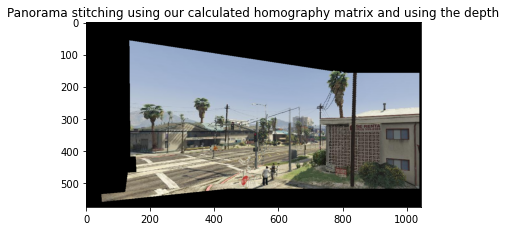

In [35]:
minx, miny, maxx, maxy = boundary((m,n),H_ours)

output_img = np.zeros((-miny+maxy+10,-minx+maxx+10,3))

output_img[-miny+5:-miny+m+5,-minx+5:-minx+n+5,:] = image2

w = weights((m,n))

# Warping Reference image to source image

for y in range(m):
    for x in range(n):
        
        # check which homography matrix to use
        d = depth_img1[int(y),int(x)][0]
        H = H_ours[int(np.floor(d/52))]
        
        new_point = H@[x,y,1] #get the new point where we are supposed to 
        new_point = np.squeeze(np.asarray(new_point))
        new_point /= new_point[2]
        
        #Transformed points
        x1 = int(new_point[0])
        y1 = int(new_point[1])

        # Finding common region for blending
        # Same pixel value is copied in a neighborhood of the transformed coordinates
        # we are taking after multiplication with weights
        if(0<x1<n and  0<y1<m):
            output_img[y1-miny+5-1:y1-miny+5+2,x1-minx+5-1:x1-minx+5+2,:] = (w[y,x]*image1[y,x,:]+w[y1,x1]*image2[y1,x1])/(w[y,x]+w[y1,x1])
        else:
            output_img[y1-miny+5-1:y1-miny+5+2,x1-minx+5-1:x1-minx+5+2,:] = image1[y,x,:]

plt.imshow(np.uint8(output_img)[:,:,::-1])
plt.title("Panorama stitching using our calculated homography matrix and using the depth")
plt.show()

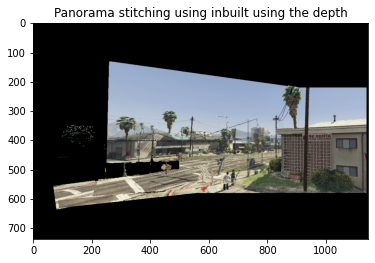

In [36]:
minx, miny, maxx, maxy = boundary((m,n),H_inbuilt)

output_img = np.zeros((-miny+maxy+10,-minx+maxx+10,3)) # we calculated the maxx and maxy so that we would avoid the overflow

# then we stored the image in our output_img

output_img[-miny+5:-miny+m+5,-minx+5:-minx+n+5,:] = image2

w = weights((m,n)) # weights after gaussian blending

# Warping Reference image to source image

# so for wraping we started iterating over all points x,y
for y in range(m):
    for x in range(n):
        
        # check which homography matrix to use
        d = depth_img1[int(y),int(x)][0]
        H = H_inbuilt[int(np.floor(d/52))]
       
        # we are now choosing the homography matrix according to depth
        new_point = H@[x,y,1] #get the new point where we are supposed to put the value of 
        new_point = np.squeeze(np.asarray(new_point))
        new_point /= new_point[2]
        
        #Transformed points
        x1 = int(new_point[0])
        y1 = int(new_point[1])

        # Finding common region for blending
        # Same pixel value is copied in a neighborhood of the transformed coordinates
        # we are taking values after multiplication with weights 
        if(0<x1<n and  0<y1<m):
            output_img[y1-miny+5-1:y1-miny+5+2,x1-minx+5-1:x1-minx+5+2,:] = (w[y,x]*image1[y,x,:]+w[y1,x1]*image2[y1,x1])/(w[y,x]+w[y1,x1])
        else:
            output_img[y1-miny+5-1:y1-miny+5+2,x1-minx+5-1:x1-minx+5+2,:] = image1[y,x,:]

plt.imshow(np.uint8(output_img)[:,:,::-1])
plt.title("Panorama stitching using inbuilt using the depth")
plt.show()

In [37]:
# panorama stitching without depth using our ransac algorithm
matchings_list = []
matchings_list_query = []
matchings_list_train = []
for i in range(len(quality_matchings)):
    img_coordinates = list(keyp1[quality_matchings[i][0].queryIdx].pt)
    img_coordinates2 = list(keyp2[quality_matchings[i][0].trainIdx].pt)
    
    x_coordinate = img_coordinates[0]
    y_coordinate = img_coordinates[1]
    x_coordinate1 = img_coordinates2[0]
    y_coordinate1 = img_coordinates2[1]
    matchings_list.append([x_coordinate,y_coordinate,x_coordinate1,y_coordinate1])
    matchings_list_query.append(img_coordinates)
    matchings_list_train.append(img_coordinates2)


Hours = ransac(np.matrix(matchings_list),5)
Hinbuilt = cv2.findHomography(np.matrix(matchings_list_query),np.matrix(matchings_list_train),cv2.RANSAC)


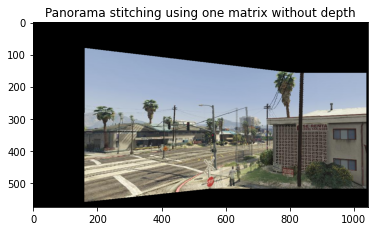

In [38]:
minx, miny, maxx, maxy = boundary((m,n),H_ours)

output_img = np.zeros((-miny+maxy+10,-minx+maxx+10,3)) # we calculated the maxx and maxy so that we would avoid the overflow

# then we stored the image in our output_img

output_img[-miny+5:-miny+m+5,-minx+5:-minx+n+5,:] = image2

w = weights((m,n)) # weights after gaussian blending

# Warping Reference image to source image

# so for wraping we started iterating over all points x,y
for y in range(m):
    for x in range(n):
        
        # check which homography matrix to use
        d = depth_img1[int(y),int(x)][0]
        
        H = Hinbuilt[0]
        H = H.reshape(H.shape[1],H.shape[0])
        
        
#         H = H_inbuilt[int(np.floor(d/52))]
        # we are now choosing the homography matrix according to depth
        new_point = H@[x,y,1] #get the new point where we are supposed to put the value of 
        new_point = np.squeeze(np.asarray(new_point))
        new_point /= new_point[2]
        
        #Transformed points
        x1 = int(new_point[0])
        y1 = int(new_point[1])

        # Finding common region for blending
        # Same pixel value is copied in a neighborhood of the transformed coordinates
        if(0<x1<n and  0<y1<m):
            output_img[y1-miny+5-1:y1-miny+5+2,x1-minx+5-1:x1-minx+5+2,:] = (w[y,x]*image1[y,x,:]+w[y1,x1]*image2[y1,x1])/(w[y,x]+w[y1,x1])
        else:
            output_img[y1-miny+5-1:y1-miny+5+2,x1-minx+5-1:x1-minx+5+2,:] = image1[y,x,:]

plt.imshow(np.uint8(output_img)[:,:,::-1])
plt.title("Panorama stitching using one matrix without depth")
plt.show()

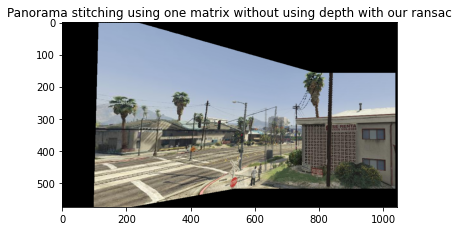

In [39]:
minx, miny, maxx, maxy = boundary((m,n),H_ours)

output_img = np.zeros((-miny+maxy+10,-minx+maxx+10,3)) # we calculated the maxx and maxy so that we would avoid the overflow

# then we stored the image in our output_img

output_img[-miny+5:-miny+m+5,-minx+5:-minx+n+5,:] = image2

w = weights((m,n)) # weights after gaussian blending

# Warping Reference image to source image

# so for wraping we started iterating over all points x,y
for y in range(m):
    for x in range(n):
        
        # check which homography matrix to use
        d = depth_img1[int(y),int(x)][0]
        
        H = Hours[0]
        H = H.reshape(H.shape[1],H.shape[0])
        
        
#         H = H_inbuilt[int(np.floor(d/52))]
        # we are now choosing the homography matrix according to depth
        new_point = H@[x,y,1] #get the new point where we are supposed to put the value of 
        new_point = np.squeeze(np.asarray(new_point))
        new_point /= new_point[2]
        
        #Transformed points
        x1 = int(new_point[0])
        y1 = int(new_point[1])

        # Finding common region for blending
        # Same pixel value is copied in a neighborhood of the transformed coordinates
        if(0<x1<n and  0<y1<m):
            output_img[y1-miny+5-1:y1-miny+5+2,x1-minx+5-1:x1-minx+5+2,:] = (w[y,x]*image1[y,x,:]+w[y1,x1]*image2[y1,x1])/(w[y,x]+w[y1,x1])
        else:
            output_img[y1-miny+5-1:y1-miny+5+2,x1-minx+5-1:x1-minx+5+2,:] = image1[y,x,:]

plt.imshow(np.uint8(output_img)[:,:,::-1])
plt.title("Panorama stitching using one matrix without using depth with our ransac")
plt.show()